<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-2-DT-Ensembles/msch_DT_Ensemble_v4_HypOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Extended Project 2: Decision Trees and Ensemble Methods**

---



Course: Computation Machine Learning II

Submission Date: Mar 27, 2022

Student: Mathias Schindler

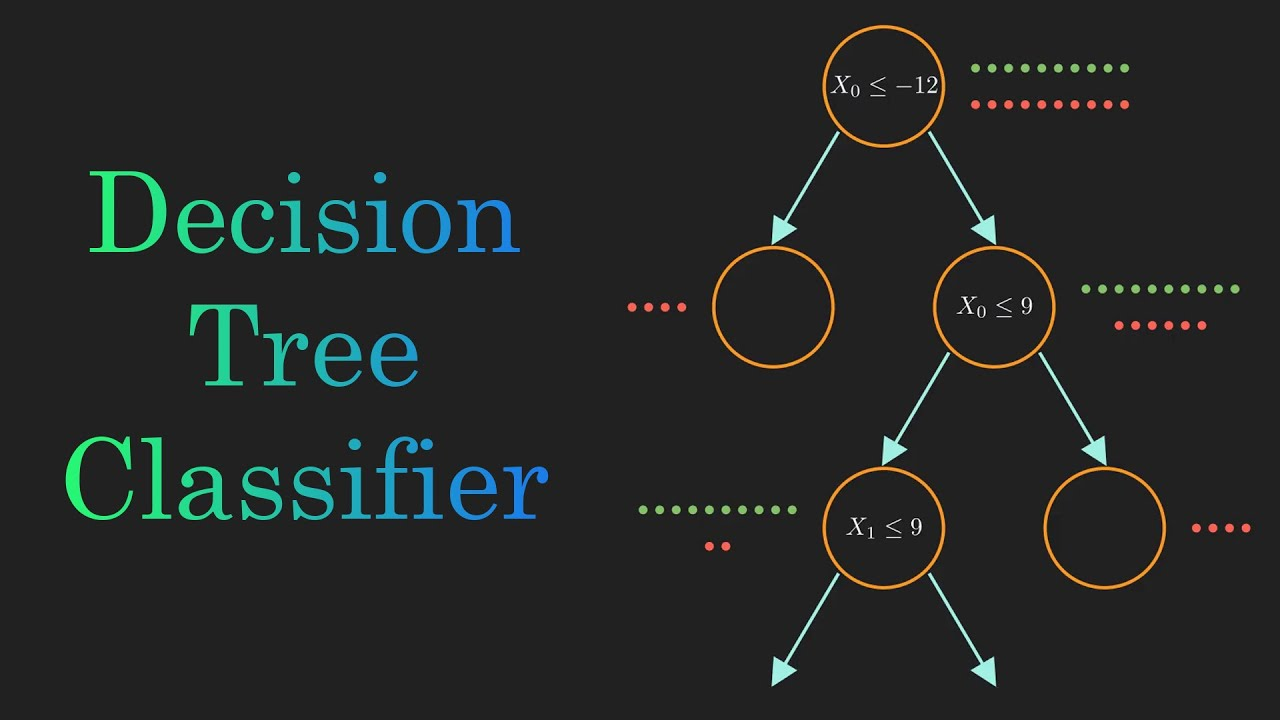

## Programming Project: Length of Stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

For the in-class assignment, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 15%
+ Data preparation - 20%
+ DT method(s) have been used - 25%
+ Length of stay for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%


# **0. Preamble**

In [1]:
# clear everything for multiple runs
%reset -f
print(dir())

['In', 'Out', '__builtin__', '__builtins__', '__name__', '_dh', '_ih', '_oh', '_sh', 'exit', 'get_ipython', 'quit']


In [2]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2/Project2_DT_Ensemble')

In [4]:
# Install libraries
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git
!pip install category_encoders
!pip install mlens
!pip install lime
!pip install shap

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-u78m_lzg
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-u78m_lzg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=b5dc21714618e2854902821c550d5e930be78562ed48a15e6f32f18ea159d64d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6cquwz7j/wheels/d6/9e/e3/8818f5597f06caa60393811f8aa57eb87b8565d772046d1b72
Successfully built scikit-optimize
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 227 kB 24.2 MB/s 
     |████████████████████████████████| 275 kB 23.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=76b123f7e3dfcde2

In [5]:
# Load libraries

# Core libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from math import sqrt


# scikit-learn
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import xgboost

# Bayesian optimizer for hyperparamters
from skopt import BayesSearchCV

# Category encoder
import category_encoders as ce
from category_encoders.woe import WOEEncoder

# For date format handling
from datetime import datetime, timedelta
import time

# Ensembling methods
from sklearn.model_selection  import ParameterGrid

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

# Saving models
import pickle

# Model interpretability 
import lime
import lime.lime_tabular
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[MLENS] backend: threading


In [6]:
# import Jack's custom functions
from utils import helper_functions as util
print(dir(util))

['GridSearch_table_plot', 'Plot_Point', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'colors', 'get_auc', 'np', 'pd', 'plot_any_cat_matrix', 'plot_boundaries_iris_dataset', 'plot_confusion_matrix', 'plot_digits_sample', 'plot_svc_decision_function', 'plt', 'random', 'roc_auc_score', 'roc_curve', 'sklearn', 'sns']


In [7]:
# import my custom functions
from schindlerlib.plots import schindler_plots as my_plots
from schindlerlib.preproz import schindler_preproz as my_preproz
from schindlerlib.postest import schindler_postest as my_postest

print(dir(my_plots)); print(dir(my_preproz)); print(dir(my_postest))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_feat_importance_plot', 'make_nan_fig', 'make_roc_plot', 'make_scree_plot', 'missing_plot', 'np', 'p_hat_plot', 'pd', 'plot_confusion_matrix', 'plt', 'sns']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'construct_age_admit', 'datetime', 'np', 'pd', 'timedelta']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_multi_point_pred', 'np', 'pd', 'reweight', 'reweight_proba_multi']


# **1. Exploratory Data Analysis**

## 1.1 Load Data

### Full Sample

In [8]:
# Load data
df_train = pd.read_csv("data/mimic_train.csv", index_col=3)
df_test = pd.read_csv("data/mimic_test_death.csv", index_col=2)

In [9]:
# Remove identifier variables
#id_vars = ['subject_id', 'hadm_id']
id_vars = ['hadm_id']

df_train = df_train.drop(id_vars, axis = 1)
df_test = df_test.drop(id_vars, axis = 1)

### Random Sample

While developing code, to check that code runs (faster runtime).

In [10]:
#df_train, df_test = df_train.sample(frac = 0.05), df_test.sample(frac = 0.05),

## 1.2 Data Types

In [11]:
# Check data types in datasets
print(df_train.dtypes); print('\n')
print(df_test.dtypes)

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
DOD                      object
ADMITTIME                object
DISCHTIME                object
DEATHTIM

Variables `GENDER`, `DOB`, `ADMITTIME`, `ADMISSION_TYPE`, `INSURANCE`, `RELIGION`, `MARITAL_STATUS`, `ETHNICITY`, `DIAGNOSIS`, `ICD9_diagnosis`, `FIRST_CAREUNIT` are string/categorical.


## 1.3 Missing Data Exploration

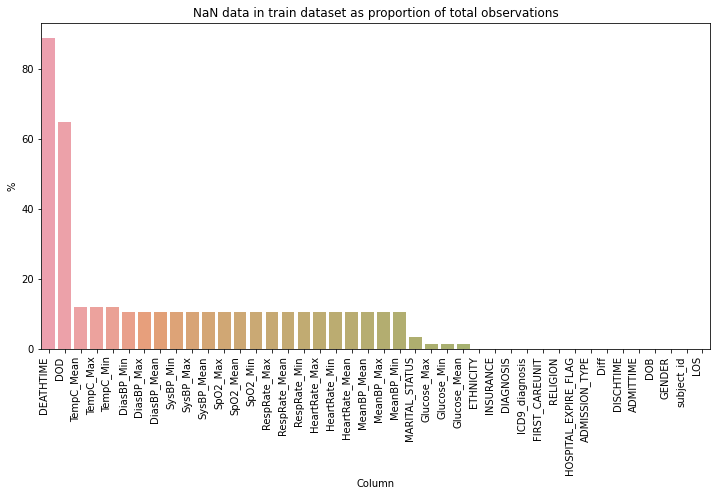

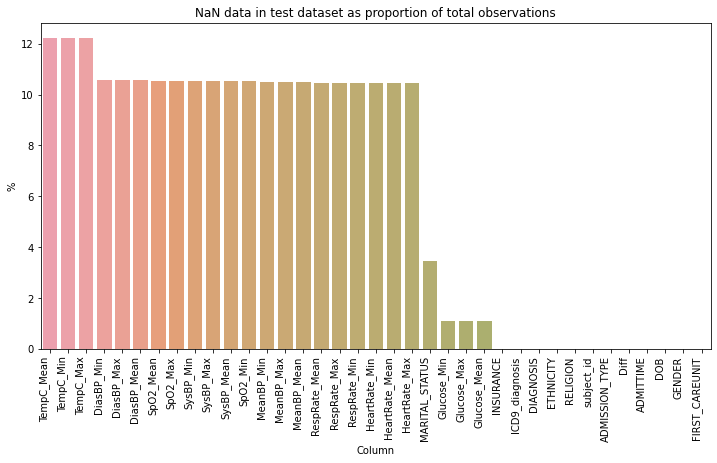

In [12]:
my_plots.missing_plot(df_train, 'train'); my_plots.missing_plot(df_test, 'test')

## 1.4 Feature Distribution

### 1.4.1 Univariate Distributions of Numerical Features

In [13]:
# Save numerical features as list
cols_list = df_train.columns.to_list()
cols_list_str =  ['GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 
                  'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 
                  'FIRST_CAREUNIT']
cols_list_nostr = [var for var in cols_list if var not in cols_list_str]

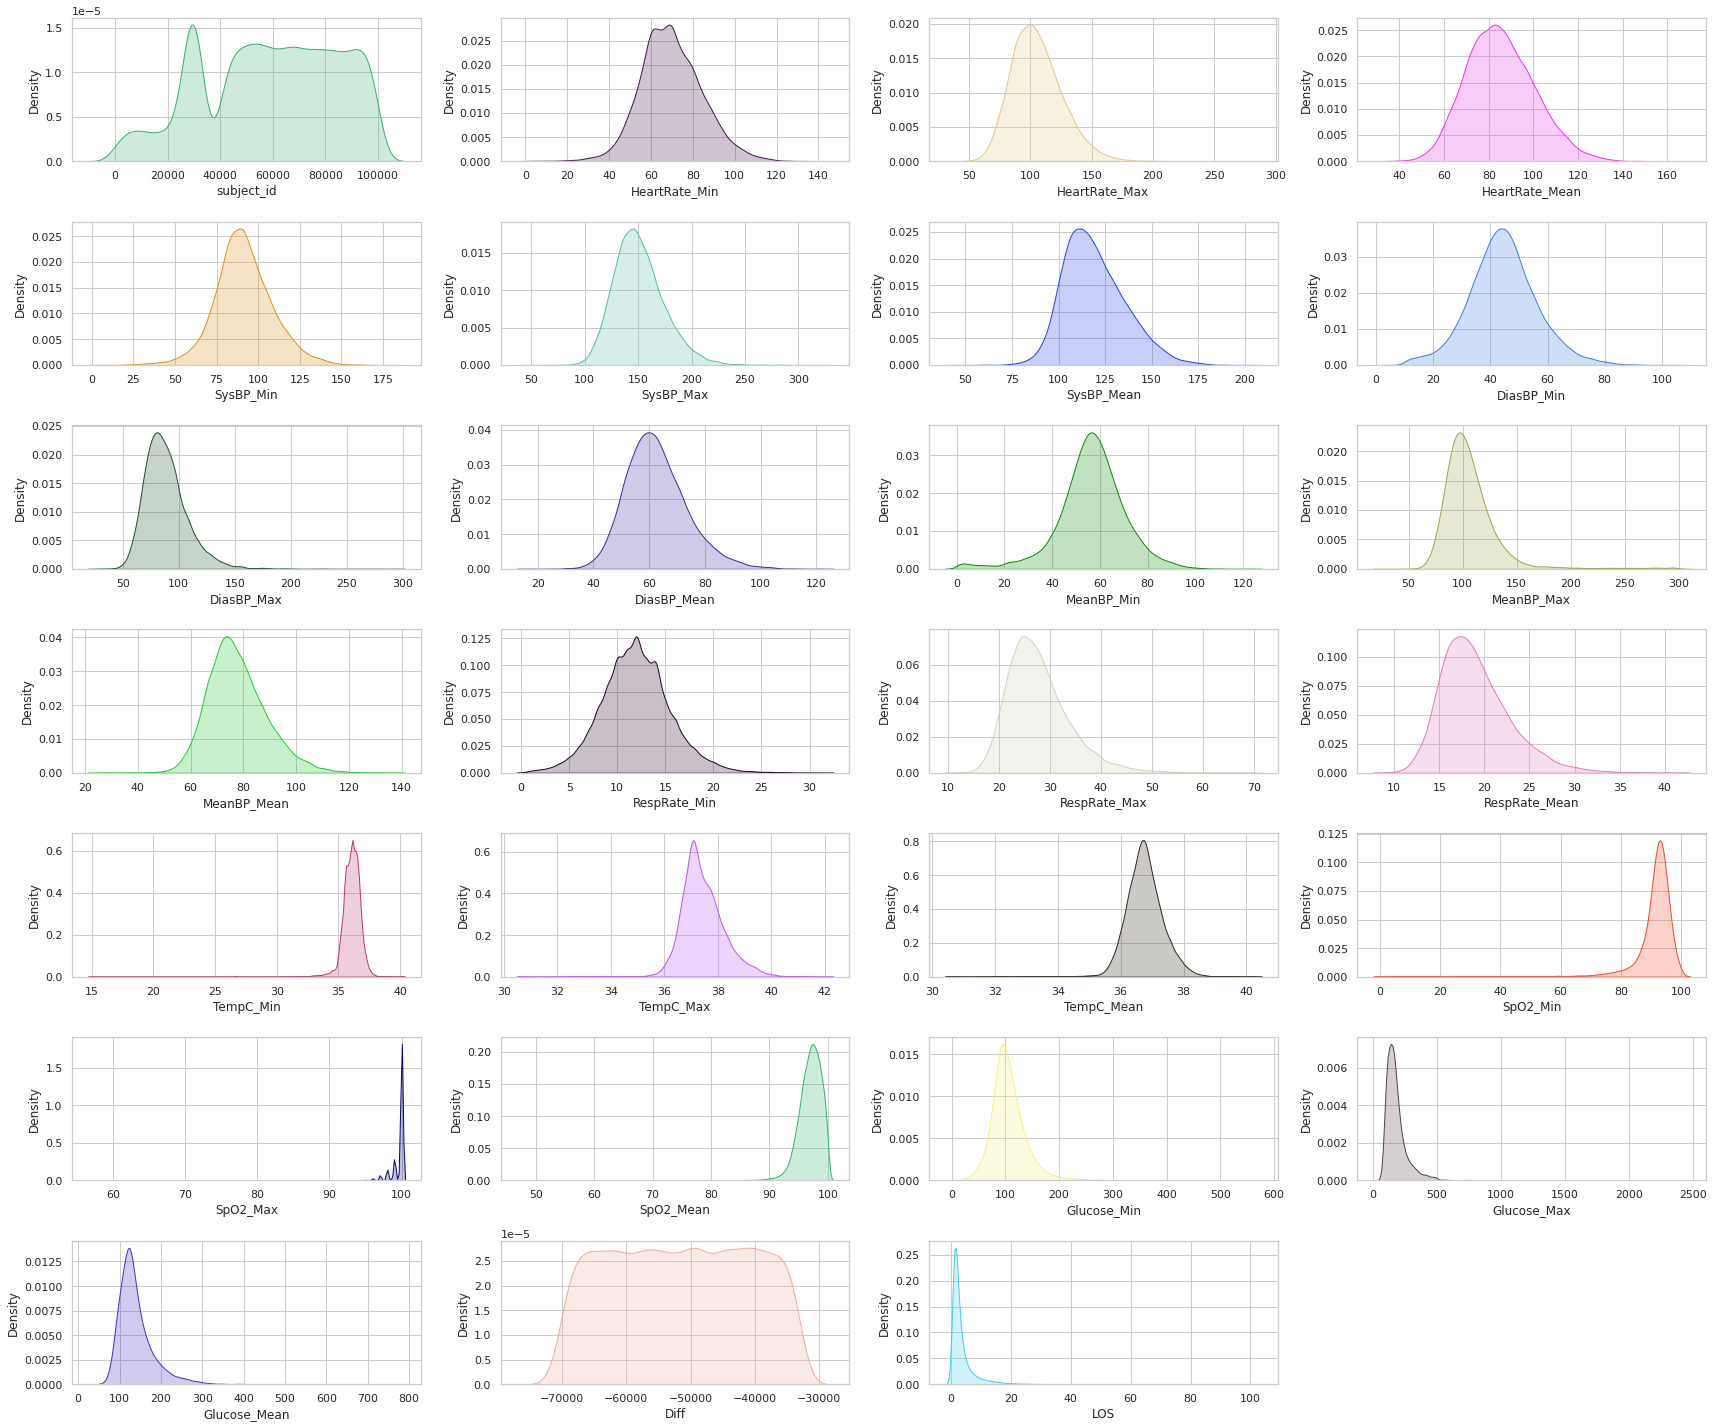

In [14]:
# Univariate kernel density distributions for continuous features
sns.set(style="whitegrid")
plt.figure(figsize=(24, 20)) # Size of the matrix plots

for i, col in enumerate(cols_list_nostr):
  if i == 0:
    pass
  else:
    plt.subplot(7, 4, i) # row, cols and i is the element to plot
    sns.kdeplot(x = col, 
                data = df_train, 
                fill=True, 
                color = np.random.rand(3,) )
plt.tight_layout()

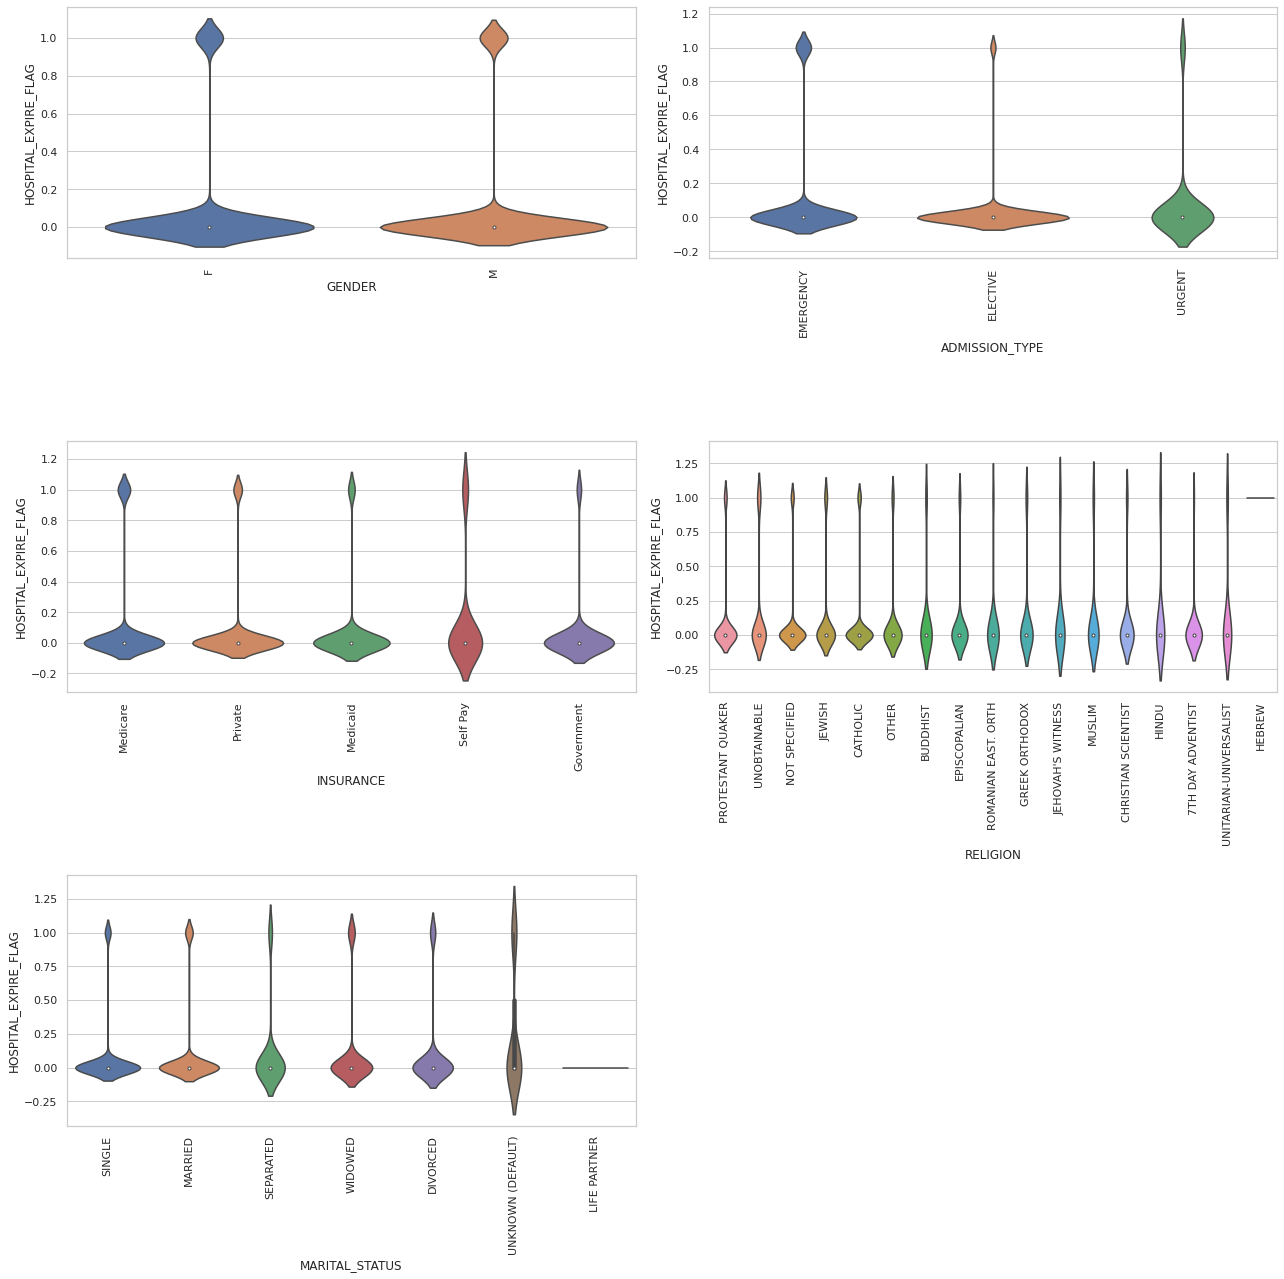

In [15]:
# Univariate violin plot distributions for categorical features
sns.set(style="whitegrid")
plt.figure(figsize=(18, 40)) # Size of the matrix plots
lst = [0, 6, 7, 8, 9]

k = 1
for i in lst:
  plt.subplot(7, 2, k) # row, cols and i is the element to plot
  sns.violinplot(x = cols_list_str[i], y = 'HOSPITAL_EXPIRE_FLAG', data = df_train )
  plt.xticks(rotation=90)
  k += 1

plt.tight_layout()

### 1.4.2 Multivariate Distributions

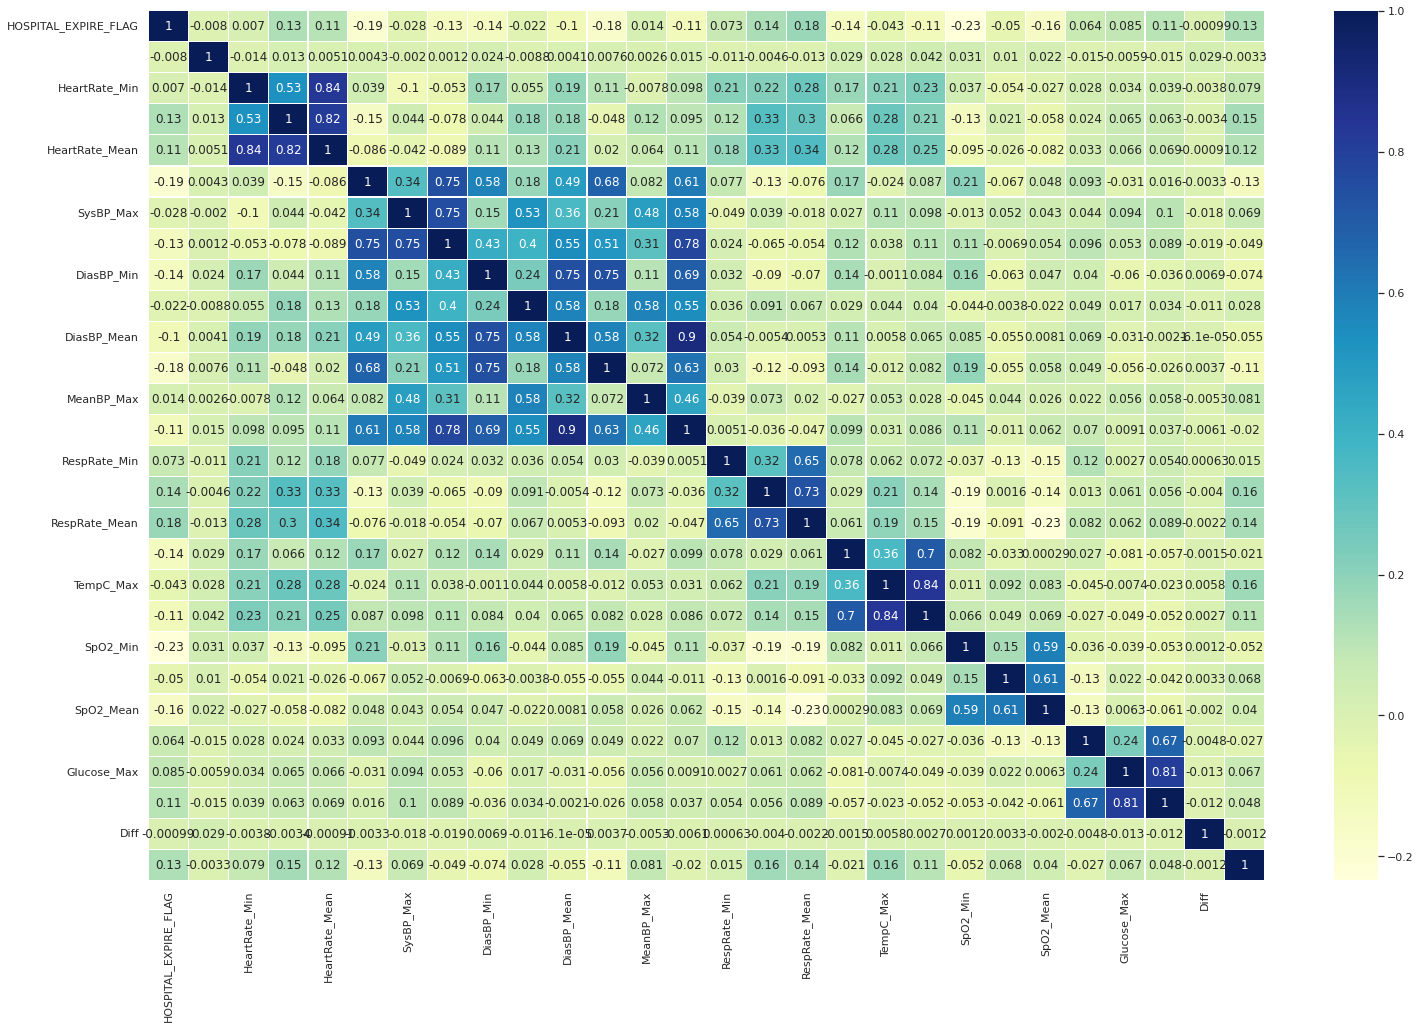

In [16]:
# Heatmap
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_train.corr(), 
            linewidths=0.1, 
            square=False, 
            cmap="YlGnBu", 
            linecolor='white', 
            annot=True)

fig = plt.gcf()
fig.set_size_inches(25, 16)

# **2. Feature Engineering**

## 2.1 Age-at-Admission Variable

### 2.1.1 Format Age Variables using `datetime`

Format admission datetime (see custom functions in external `.py`-file with custom functions).

In [17]:
%%time
df_train_age = my_preproz.construct_age_admit(df_train)
df_test_age = my_preproz.construct_age_admit(df_test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 23.1 s, sys: 426 ms, total: 23.6 s
Wall time: 23.2 s


### 2.1.2 Inspect Constructed Age Variables

In [18]:
# Check if missing values were generated
print(df_train_age['age_at_admin'].isnull().any() )
print(df_test_age['age_at_admin'].isnull().any() )

False
False


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


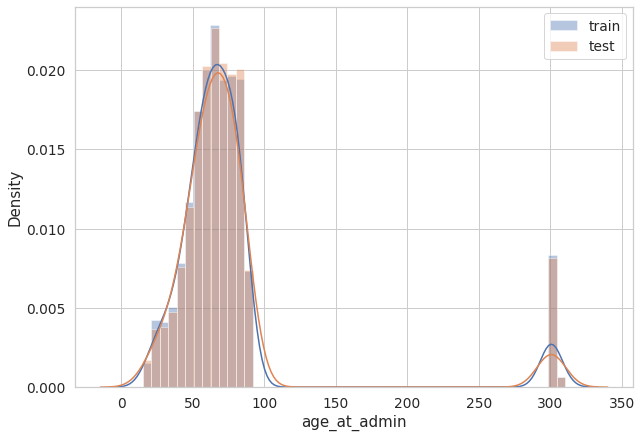

In [19]:
# Check distribution

# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train')
sns.distplot(df_test_age['age_at_admin'], label='test')

# Add legend
plt.legend()

In [20]:
# Save correct ages (for later comparison)
orig_age_train = df_train_age[df_train_age['age_at_admin'] < 250]
orig_age_test = df_test_age[df_test_age['age_at_admin'] < 250]

In [21]:
#Counts of >100-year-olds 
print("No. of individuals in train more than 100 years old: " + str(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in train for those >100 years:")
print(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

print("\n")

print("No. of individuals in test more than 100 years old: " + str(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in test for those >100 years:")
print(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

No. of individuals in train more than 100 years old: 1107

 Value counts in train for those >100 years:
299.994524    795
300.054757      4
300.021903      3
300.049281      3
301.648186      3
             ... 
300.487337      1
300.514716      1
301.530459      1
301.215606      1
300.788501      1
Name: age_at_admin, Length: 270, dtype: int64


No. of individuals in test more than 100 years old: 270

 Value counts in test for those >100 years:
299.994524    201
300.027379      2
304.859685      2
310.272416      1
304.262834      1
             ... 
300.202601      1
301.059548      1
304.150582      1
302.592745      1
300.539357      1
Name: age_at_admin, Length: 68, dtype: int64


So, those individuals over 100 years old are calculated to be between 299 to 303 years old. Seems quite unrealistic. The next section deals with cleaning this discrepancy.

### 2.1.3 Clean Constructed Age Variables

In [22]:
# Set >100 year olds to NaN
df_train_age.loc[df_train_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_test_age.loc[df_test_age.age_at_admin >= 100, 'age_at_admin'] = np.nan

# Print counts of new NaNs
print("# >100 year-olds in train: ", df_train_age['age_at_admin'].isna().sum())
print("# >100 year-olds in test: ", df_test_age['age_at_admin'].isna().sum())

# Add indicator if missing age_at_admission (for later inspection)
df_train_age['age_NA'] = df_train_age['age_at_admin'].isnull().astype(int)   
df_test_age['age_NA'] = df_test_age['age_at_admin'].isnull().astype(int)   

# >100 year-olds in train:  1107
# >100 year-olds in test:  270


In [23]:
print("Missing indicator in train:\n", df_train_age['age_NA'].value_counts()); print("\n")
print("Missing indicator in test:\n", df_test_age['age_NA'].value_counts())

Missing indicator in train:
 0    19778
1     1107
Name: age_NA, dtype: int64


Missing indicator in test:
 0    4951
1     270
Name: age_NA, dtype: int64


In [24]:
# Set numerical data frame
feats_train = df_train_age.drop(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 
                    'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'ICD9_diagnosis',
                    'DOD', 'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], 
                   axis = 1)
feats_test = df_test_age.drop(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 
                    'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'ICD9_diagnosis'], 
                   axis = 1)


# Set list of index for individuals w. >100 year-olds
age_na_train = feats_train[feats_train['age_at_admin'].isnull()].index.tolist()
age_na_test = feats_test[feats_test['age_at_admin'].isnull()].index.tolist()

I also add my auxiliary comorbidities dataset as I suspect this might help with $k$-NN imputation. Please refer to Sections 2.2 and 3.4 for further explanations about construction methodology of comobidity information.

In [25]:
# Load prepared comorbidities dataset
comorb_url = "https://raw.githubusercontent.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/main/Project-1-kNN_SVM/data/comorb_final-2022-02-08-10-52.csv"
comorb = pd.read_csv(comorb_url, index_col=0)
comorb_add = comorb.drop('charlson_score', axis = 1)

# Merge
feats_train = feats_train.merge(comorb_add, how = 'left', on = "subject_id", indicator = True)
feats_test = feats_test.merge(comorb_add, how = 'left', on = "subject_id", indicator = True)

# Drop unnecesary cols
feats_train = feats_train.drop(['subject_id', '_merge'], axis = 1)
feats_test = feats_test.drop(['subject_id', '_merge'], axis = 1)

# Reset index
feats_train = feats_train.set_index(df_train_age.index)
feats_test = feats_test.set_index(df_test_age.index)

#Inspect
feats_test.head(3)
feats_train.head(3)

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,0,0,0,0,0,1,0,0,0,0
221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,0,0,0,0,0,0,0,0,0,0
296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,0,0,1,0,0,1,0,0,0,0


In [26]:
%%time
# Instantiate imputer
knn_imput = KNNImputer(n_neighbors = 1000)

# Fit
knn_imput.fit(feats_train)

# Transform
age_train_knn = knn_imput.transform(feats_train)
age_test_knn = knn_imput.transform(feats_test)

# Make pd.DataFrame
age_train_knn = pd.DataFrame(age_train_knn, 
                    columns = knn_imput.feature_names_in_,
                    index = feats_train.index)
age_test_knn = pd.DataFrame(age_test_knn, 
                    columns = knn_imput.feature_names_in_,
                    index = feats_test.index)

# Value counts 
print('Train: \n', age_train_knn['age_at_admin'].loc[age_na_train].value_counts()); print("\n")
print('Test: \n', age_test_knn['age_at_admin'].loc[age_na_test].value_counts())

Train: 
 62.035767    2
66.135217    1
62.558491    1
63.094530    1
63.498053    1
            ..
61.333361    1
66.375050    1
60.655978    1
62.177476    1
57.743359    1
Name: age_at_admin, Length: 1106, dtype: int64


Test: 
 63.945593    1
62.344934    1
65.926984    1
64.016235    1
59.295151    1
            ..
63.768454    1
64.659321    1
62.821758    1
62.396430    1
63.461175    1
Name: age_at_admin, Length: 270, dtype: int64
CPU times: user 43.6 s, sys: 1.62 s, total: 45.2 s
Wall time: 43.4 s


In [27]:
# Overwrite original 'age_at_admin' with new k-NN-imputed age variables in original datasets
df_train_age['age_at_admin'] = age_train_knn['age_at_admin']
df_test_age['age_at_admin'] = age_test_knn['age_at_admin']

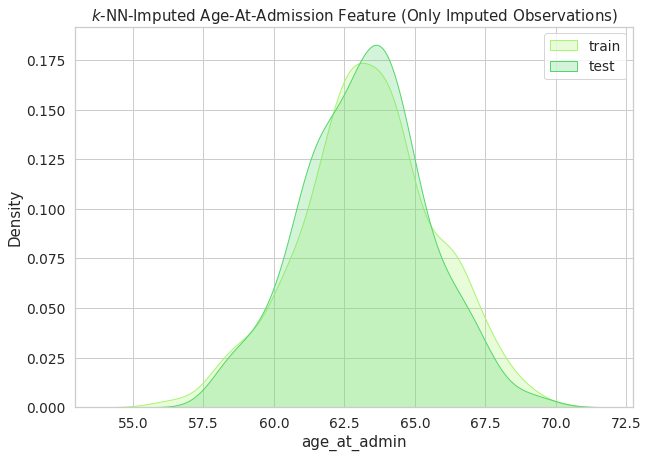

In [28]:
# Distribution of kNN-imputed age

sns.kdeplot(x = 'age_at_admin', 
            data = df_train_age[df_train_age['age_NA'] == 1], 
            fill=True, 
            color = np.random.rand(3,),
            label = 'train')
sns.kdeplot(x = 'age_at_admin', 
            data = df_test_age[df_test_age['age_NA'] == 1], 
            fill=True, 
            color = np.random.rand(3,),
            label = 'test')

plt.legend()
plt.title("$k$-NN-Imputed Age-At-Admission Feature (Only Imputed Observations)")
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


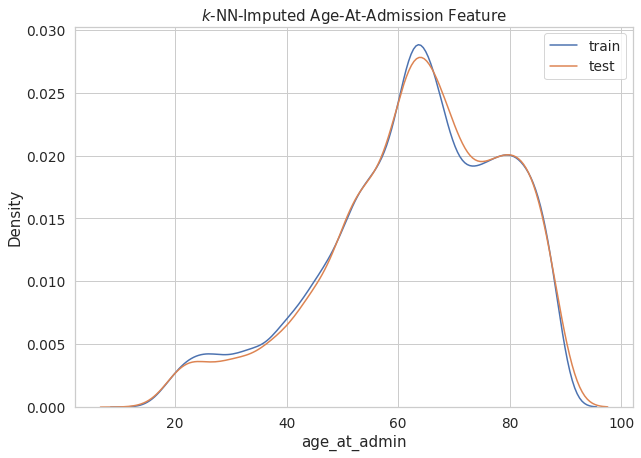

In [29]:
# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train', hist = False)
sns.distplot(df_test_age['age_at_admin'], label='test', hist = False)

# Add legend
plt.legend()
plt.title("$k$-NN-Imputed Age-At-Admission Feature")
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


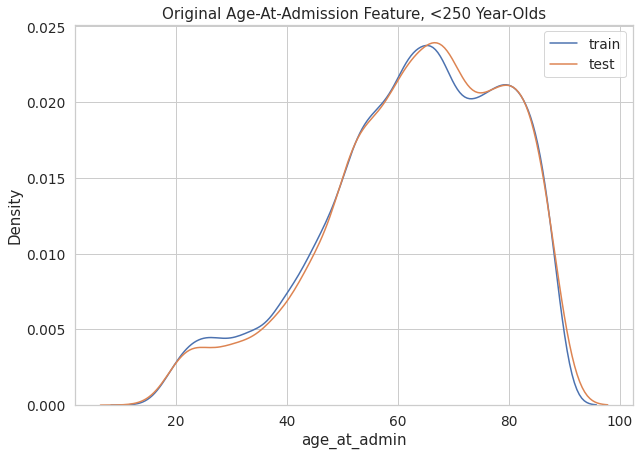

In [30]:
# Check distribution for original <250 year-olds (for comparison)

# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(orig_age_train['age_at_admin'], label='train', hist = False)
sns.distplot(orig_age_test['age_at_admin'], label='test', hist = False)

# Add legend
plt.legend()
plt.title("Original Age-At-Admission Feature, <250 Year-Olds")
plt.show()

It is seen that the imputation of >100 year olds has especially increased the observed patients in the age group $\sim$ 60–70.

## 2.2 Co-Morbitidity Information

Please refer to the auxiliary notebook `comorb_transform.ipynb` ([this GitHub-link](https://github.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-1-kNN/comorb_transform.ipynb)) where comorbidities are transformed using the `icd` package in `R`. Also Section 3.4 where the comorbodities are merged to the main dataset. Here I mainly present my auxiliary constructed dataset with comorbidities as this is a part of the feature engineering process.

In [31]:
comorb_url = "https://raw.githubusercontent.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/main/Project-1-kNN_SVM/data/comorb_final-2022-02-08-10-52.csv"
comorb = pd.read_csv(comorb_url, index_col=0)
comorb

,subject_id,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV,charlson_score
1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1000,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,5
4,10000,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,6
5,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46516,9999,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
46517,99991,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2
46518,99992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46519,99995,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3


# **3. Preprocessing**

## 3.0 Compare Features in Train and Test

Compare features in both data sets

In [32]:
df_train_fillna, df_test_fillna = df_train_age, df_test_age

In [33]:
print("Features in train data but not in test:")
print(df_train_fillna.columns.difference(df_test_fillna.columns) )

print("\n Features in test data but not in train:")
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Features in train data but not in test:
Index(['DEATHTIME', 'DISCHTIME', 'DOD', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], dtype='object')

 Features in test data but not in train:
Index([], dtype='object')


In [34]:
# Remove features in train that are not in test (except target 'HOSPITAL_EXPIRE_FLAG')
df_train_fillna = df_train_fillna.drop(['DISCHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DEATHTIME', 'DOD',], axis = 1)

In [35]:
print(df_train_fillna.columns.difference(df_test_fillna.columns) )
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Index(['LOS'], dtype='object')
Index([], dtype='object')


## 3.1 Inspect Missing Values

To be dealt with later in Sections 3.3.3 and 3.4.5

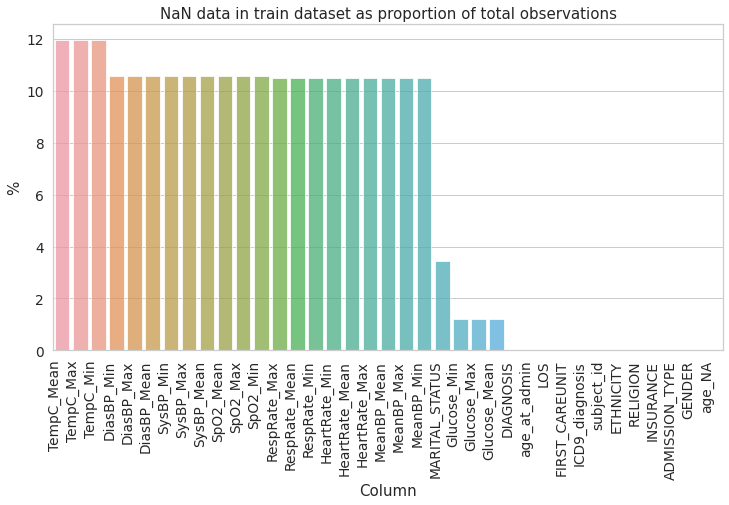

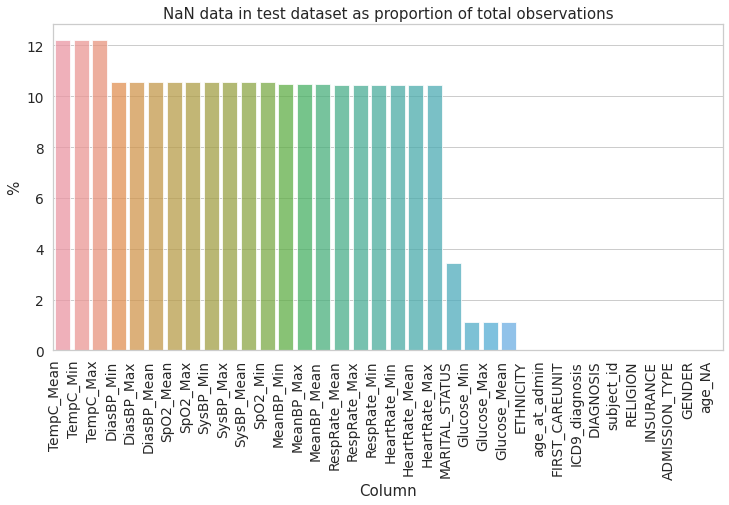

In [36]:
# Investigate missing data
my_plots.missing_plot(df_train_fillna, 'train'); my_plots.missing_plot(df_test_fillna, 'test')

## 3.2 Split Categorical and Numerical Data

In [37]:
# Numerical Data
cat_feats = ["subject_id", "GENDER", "ADMISSION_TYPE", "INSURANCE", "FIRST_CAREUNIT", "MARITAL_STATUS", "RELIGION",
             "ETHNICITY", "ICD9_diagnosis", "DIAGNOSIS"]

df_train_num = df_train_fillna.drop(cat_feats, axis = 1)
df_test_num = df_test_fillna.drop(cat_feats, axis = 1)

In [38]:
# Categorical Data
df_train_cat = df_train_fillna[cat_feats]
df_train_cat = df_train_cat.drop("subject_id", axis = 1)

df_test_cat = df_test_fillna[cat_feats]
df_test_cat = df_test_cat.drop("subject_id", axis = 1)

In [39]:
# Split target
y_train = df_train_fillna['LOS']
df_train_num = df_train_num.drop(['LOS'], axis = 1)

Compare again

In [40]:
# Compare numerical features
print(df_train_num.columns.difference(df_test_num.columns) )
print(df_test_num.columns.difference(df_train_num.columns) )

Index([], dtype='object')
Index([], dtype='object')


In [41]:
# Compare categorical features
print(df_train_cat.columns.difference(df_test_cat.columns) )
print(df_test_cat.columns.difference(df_train_cat.columns) )

Index([], dtype='object')
Index([], dtype='object')


## 3.3 Numerical Features 

### 3.3.1 Polynomial Transformations

Not necessary for decision trees as the algorithms already captures this structure and incorporating would slow minimization of variance down.

### 3.3.2 Standardization

Data will be standardized with mean zero and unit variance. This such that distance measures are in comparable units.

In [42]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to train 
scaler.fit(df_train_num)

# Transform train and test
df_train_scl = scaler.transform(df_train_num)
df_test_scl = scaler.transform(df_test_num)

# Format data
df_train_scl = pd.DataFrame(df_train_scl, 
                            columns = df_train_num.columns, 
                            index = df_train_num.index)
df_test_scl = pd.DataFrame(df_test_scl, 
                           columns = df_test_num.columns, 
                           index = df_test_num.index)

### 3.3.3 Imputing NaNs

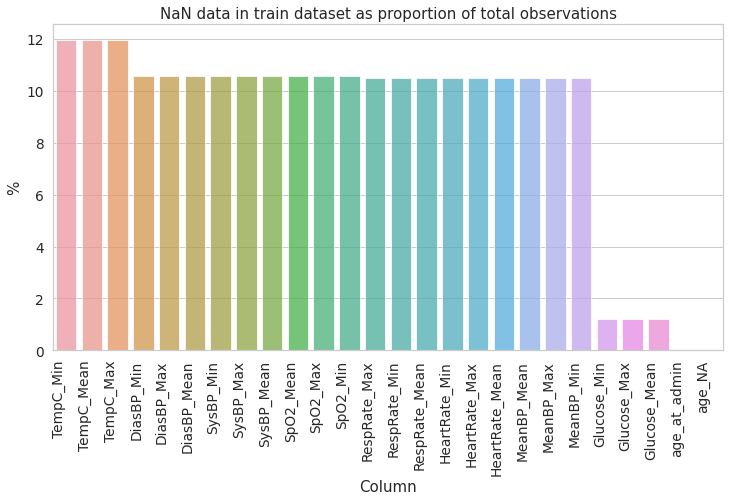

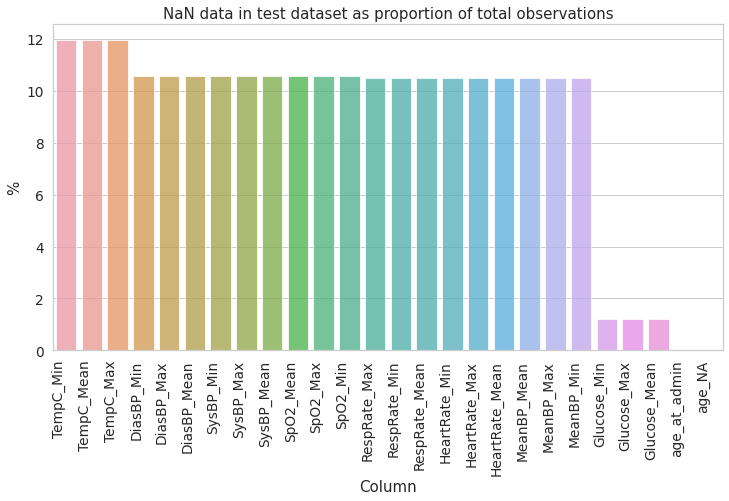

In [43]:
# Investigate missing data
my_plots.missing_plot(df_train_scl, 'train'); my_plots.missing_plot(df_train_scl, 'test')

I use `IterativeImputer` from `sklearn.experimental` for imputing NaNs as this has yielded me the best results.

In [44]:
%%time
#Instantiate imputer
imp_nums = IterativeImputer(random_state = 0)

# Fit
imp_nums.fit(df_train_scl)

# Transform
df_train_scl = imp_nums.fit_transform(df_train_scl)
df_test_scl = imp_nums.transform(df_test_scl)

# pd.DataFrames
df_train_scl = pd.DataFrame(df_train_scl,
                            columns = df_train_num.columns,
                            index = df_train_num.index)
df_test_scl = pd.DataFrame(df_test_scl,
                            columns = df_test_num.columns,
                            index = df_test_num.index)

# Inspect
print(df_train_scl.isna().any()); print(df_test_scl.isna().any())

[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.


HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
TempC_Min         False
TempC_Max         False
TempC_Mean        False
SpO2_Min          False
SpO2_Max          False
SpO2_Mean         False
Glucose_Min       False
Glucose_Max       False
Glucose_Mean      False
age_at_admin      False
age_NA            False
dtype: bool
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
Temp

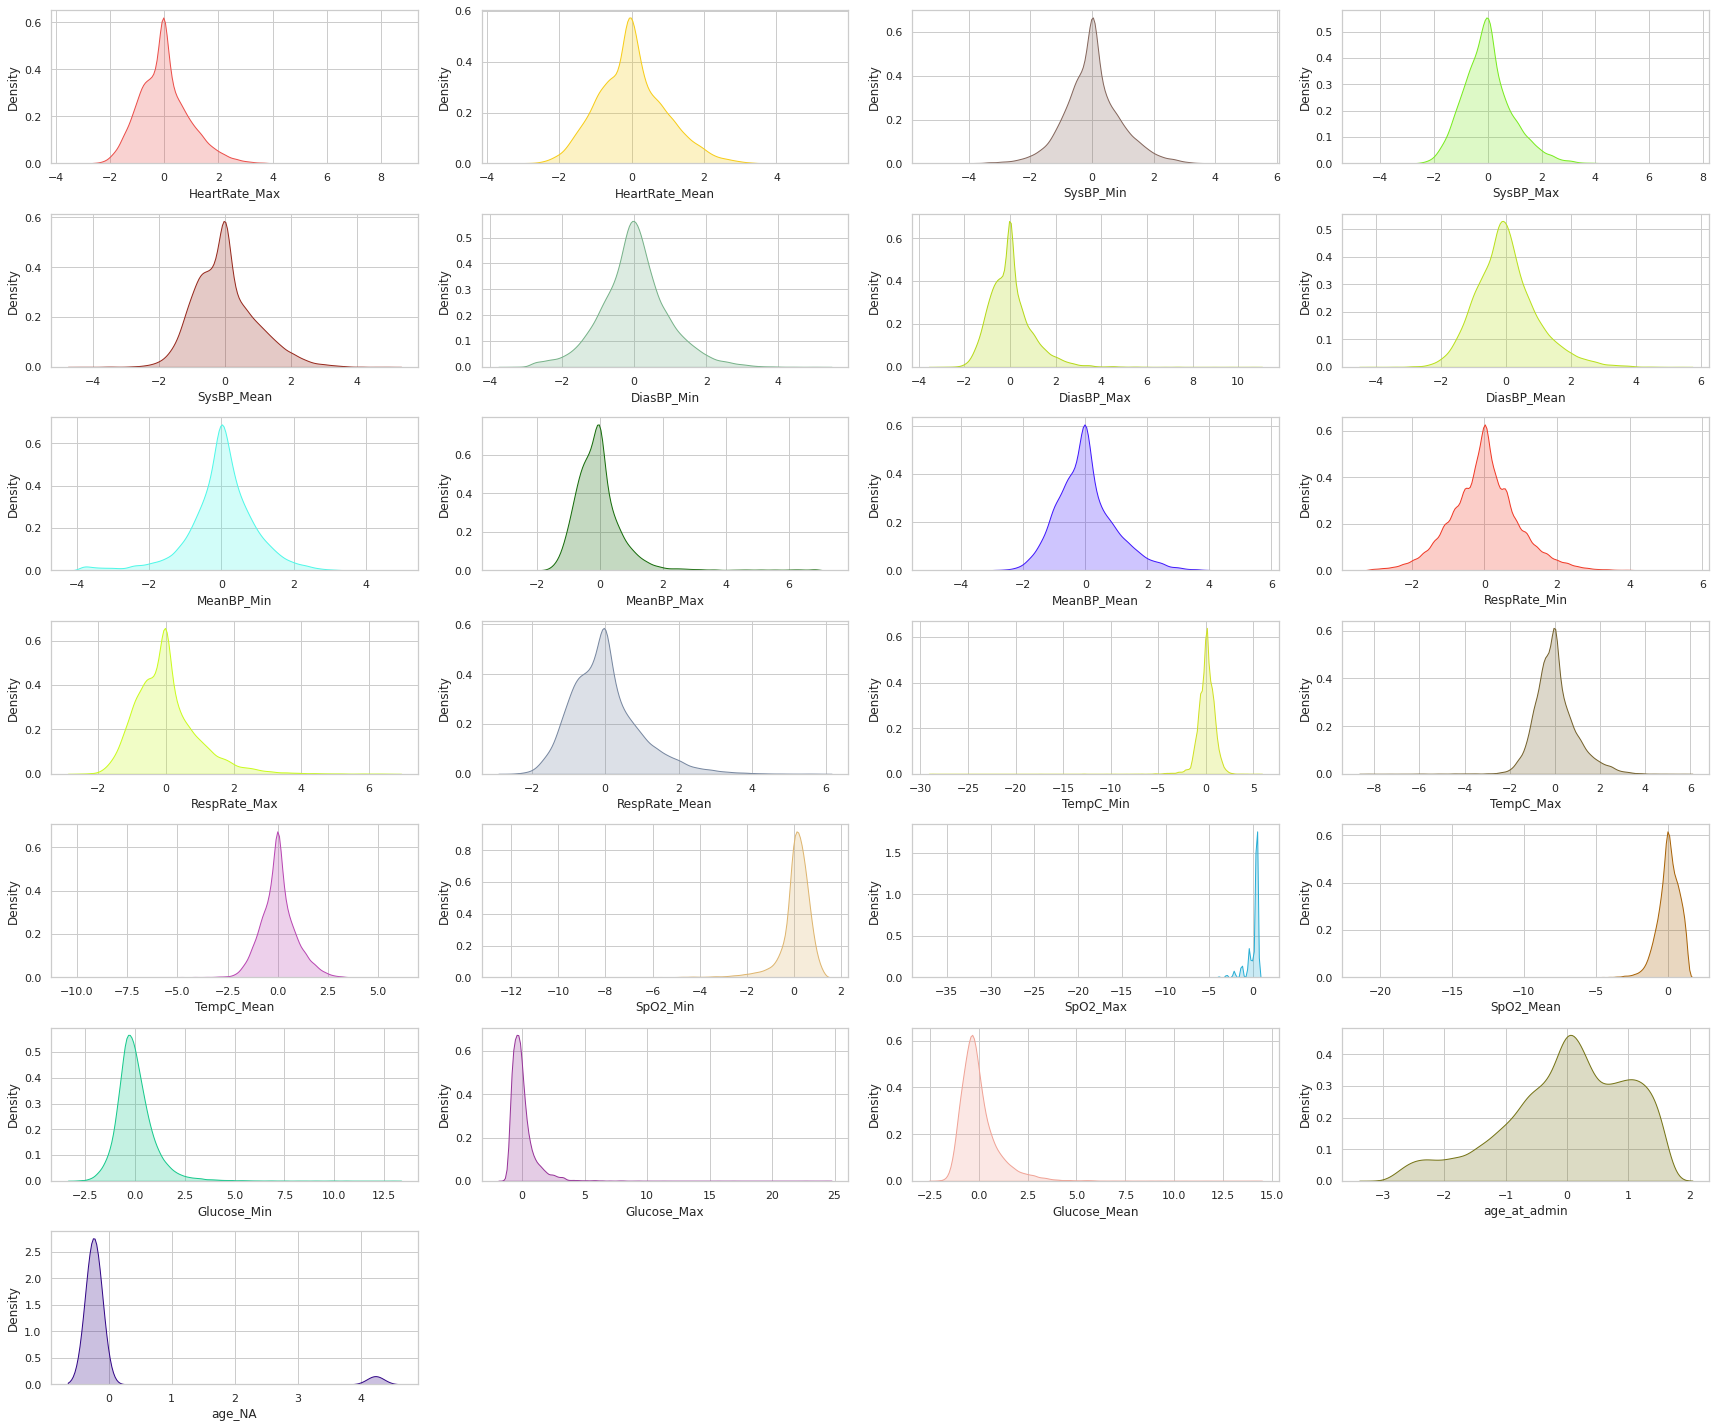

In [45]:

# Visualizing numerical features after standardization
cols_list_scl = df_train_scl.columns.to_list()

sns.set(style="whitegrid")
plt.figure(figsize=(24, 20)) # Size of the matrix plots

for i, col in enumerate(cols_list_scl):
  if i == 0:
    pass
  else:
    plt.subplot(7, 4, i) # row, cols and i is the element to plot
    sns.kdeplot(x = col, 
                data = df_train_scl, 
                fill=True, 
                color = np.random.rand(3,) )
plt.tight_layout()

## 3.4 Categorical Features

### 3.4.1 Exploration

Inspecting for which features which imputation method seems most appropraite.

In [46]:
cat_feats.remove('subject_id')

In [47]:
# Count number of categories for each categorical feature
print("#Categories in each categorical feature\n")
for c in cat_feats:
  print(str(c) + ": " + str(df_train_cat[c].nunique(dropna = False))); print("\n")

#Categories in each categorical feature

GENDER: 2


ADMISSION_TYPE: 3


INSURANCE: 5


FIRST_CAREUNIT: 5


MARITAL_STATUS: 8


RELIGION: 17


ETHNICITY: 41


ICD9_diagnosis: 1853


DIAGNOSIS: 6193




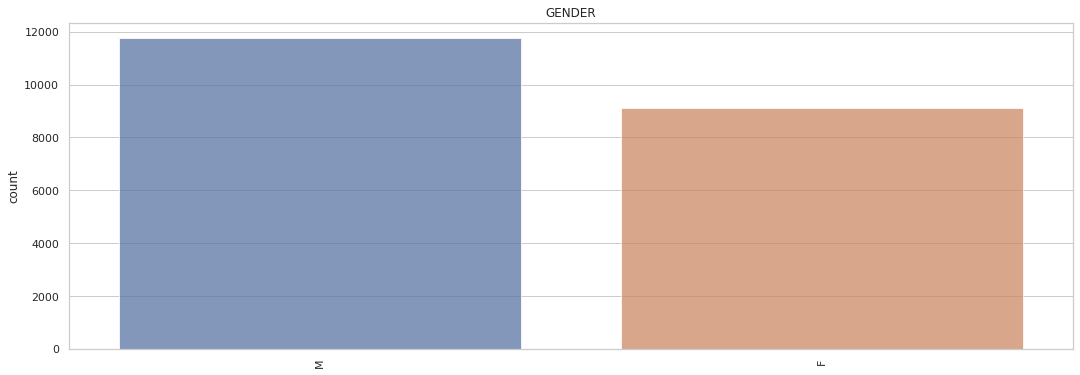

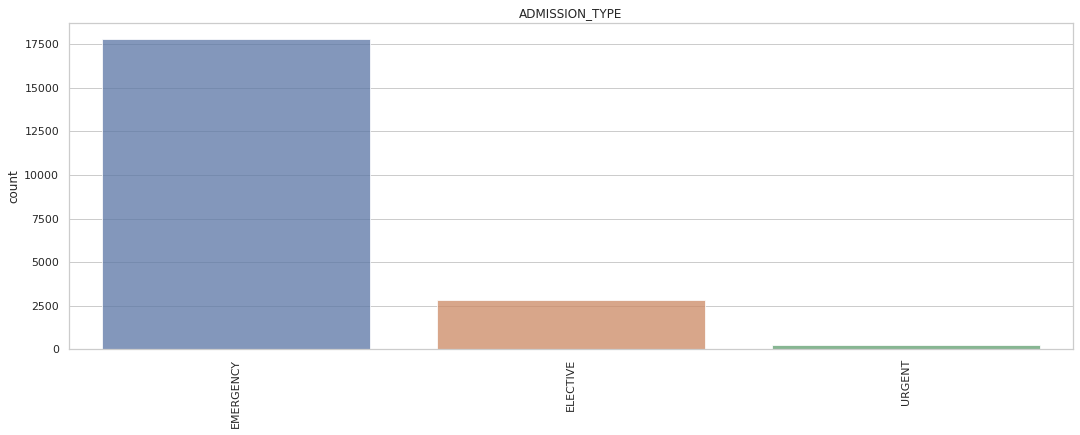

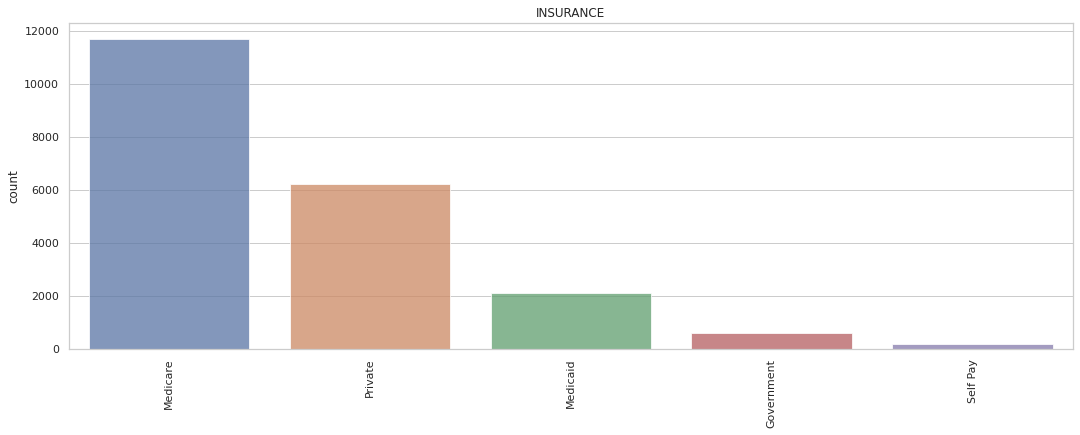

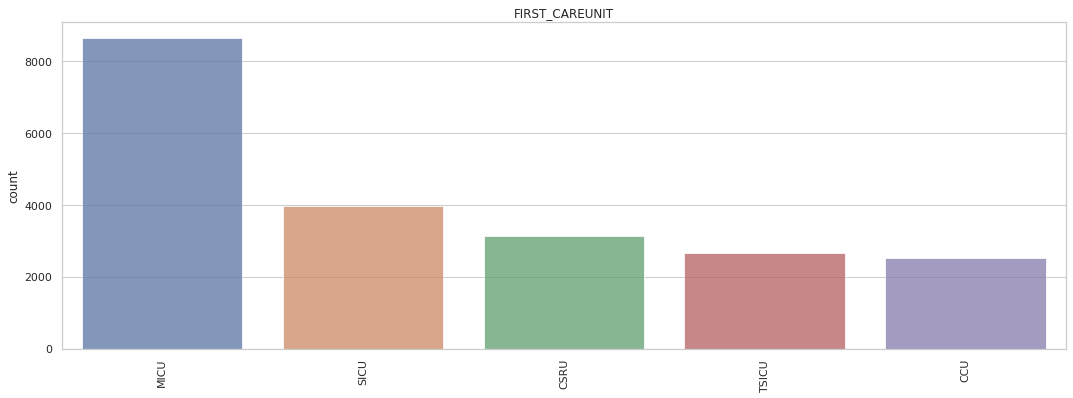

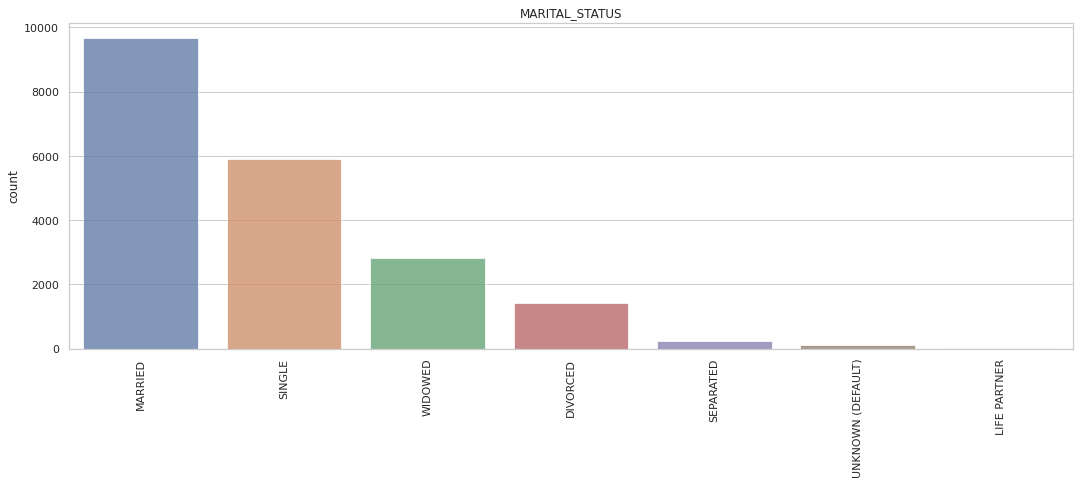

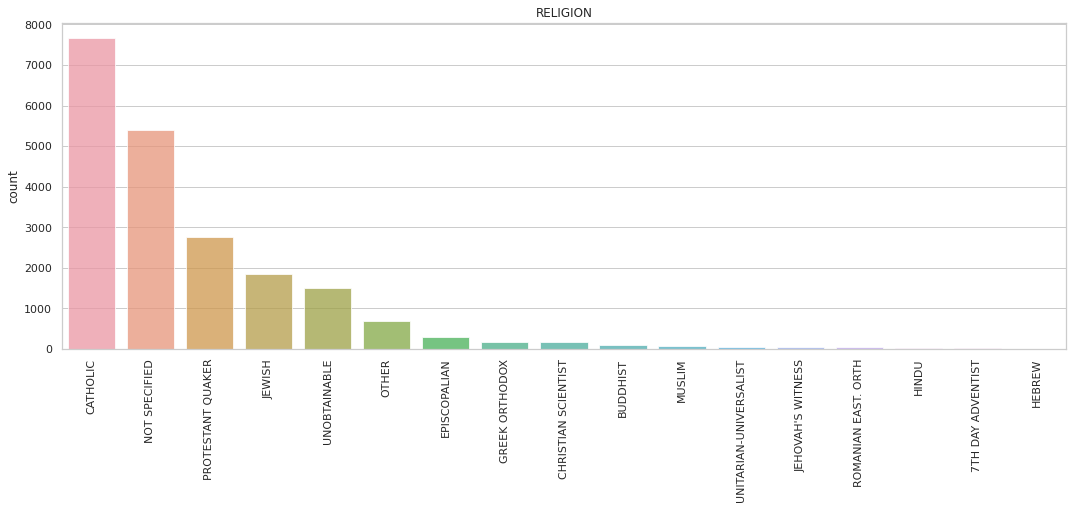

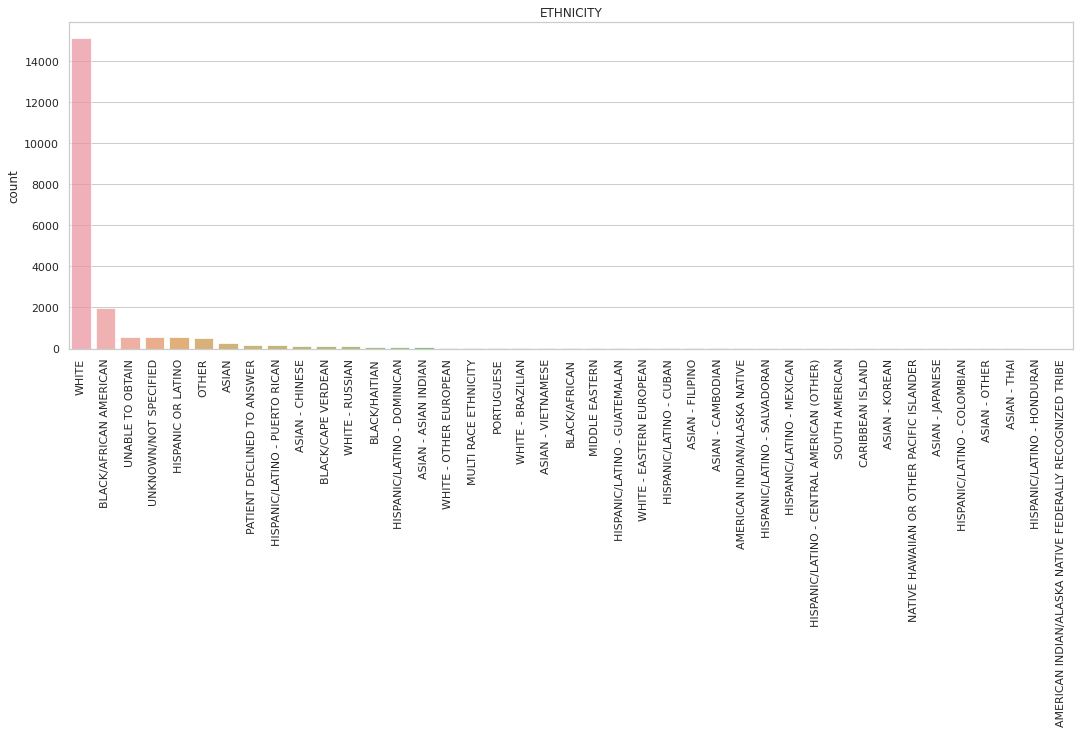

In [48]:
# Visualize counts of categories
remove = ['ICD9_diagnosis', 'DIAGNOSIS']
cat_feats_figs = [cat for cat in cat_feats if cat not in remove]

for c in cat_feats_figs:
  plt.figure().set_size_inches(18, 6)
  ax = sns.countplot(data = df_train_cat, 
                     x = c,
                     order = df_train_cat[c].value_counts().index,
                     alpha = 0.75)
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
  ax.set_title(str(c))
  ax.set(xlabel='')
  plt.show()

### 3.4.2 Binary Encoding

I now use binary encoding for all categorical variables except `ICD9_diagnosis` and `DIAGNOSIS`. The latter two have many categories whereby dimensionality would increase. This would be too computationally expensive to fit a model and/or pipeline on (especially for SVM).

In [49]:
# Instantiate
ce_bin = ce.BinaryEncoder(cols = cat_feats_figs)

# Fit
ce_bin.fit(df_train_cat, y_train)

# Transform
df_train_dumm1 = ce_bin.transform(df_train_cat)
df_test_dumm1 = ce_bin.transform(df_test_cat)

# Remove 'ICD9_diagnosis' and 'DIAGNOSIS'
remove = ['ICD9_diagnosis', 'DIAGNOSIS']
df_train_dumm1 = df_train_dumm1.drop(remove, axis = 1)
df_test_dumm1 = df_test_dumm1.drop(remove, axis = 1)

# Print results
print('Shape: ', df_train_dumm1.shape); df_train_dumm1.head()

Shape:  (20885, 25)


,GENDER_0,GENDER_1,ADMISSION_TYPE_0,ADMISSION_TYPE_1,INSURANCE_0,INSURANCE_1,INSURANCE_2,FIRST_CAREUNIT_0,FIRST_CAREUNIT_1,FIRST_CAREUNIT_2,...,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4,ETHNICITY_0,ETHNICITY_1,ETHNICITY_2,ETHNICITY_3,ETHNICITY_4,ETHNICITY_5
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,0,1,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
221004,0,1,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
296315,0,1,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
245557,0,1,1,0,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,1
225281,0,1,0,1,0,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,1


### 3.4.3 Weight of Evidence Encoding

Even though binary encoding `ICD9_diagnosis` and `DIAGNOSIS` only adds 24 features to the above dataframe, I prefer to use the method of Weight of Evidence encoding which only adds two features (one for each).

In [50]:
# Set features to transform
remove = ['ICD9_diagnosis', 'DIAGNOSIS']
train_te, test_te = df_train_cat[remove], df_test_cat[remove]

In [51]:
# Instantiate encoder
woe = ce.BinaryEncoder()

# Fit
woe.fit(train_te, y_train)

# Transform
df_train_dumm2 = woe.transform(train_te)
df_test_dumm2 = woe.transform(test_te)

# Print results
print('Shape: ', df_train_dumm2.shape); df_test_dumm2.head()

Shape:  (20885, 24)


,ICD9_diagnosis_0,ICD9_diagnosis_1,ICD9_diagnosis_2,ICD9_diagnosis_3,ICD9_diagnosis_4,ICD9_diagnosis_5,ICD9_diagnosis_6,ICD9_diagnosis_7,ICD9_diagnosis_8,ICD9_diagnosis_9,...,DIAGNOSIS_3,DIAGNOSIS_4,DIAGNOSIS_5,DIAGNOSIS_6,DIAGNOSIS_7,DIAGNOSIS_8,DIAGNOSIS_9,DIAGNOSIS_10,DIAGNOSIS_11,DIAGNOSIS_12
icustay_id,,,,,,,,,,,,,,,,,,,,,
208169,0,0,0,0,0,0,0,1,1,0,...,0,1,1,1,0,1,0,1,1,1
251754,0,0,0,0,1,0,1,1,0,0,...,0,1,0,0,0,1,0,1,0,0
242171,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
263035,0,1,1,1,0,0,1,0,0,1,...,1,0,0,1,0,1,0,1,1,0
279388,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### 3.4.4 Concatenate Encoded Categorical Data Frames

In [52]:
df_train_dumm = pd.concat([df_train_dumm2, df_train_dumm1], axis = 1)
df_test_dumm = pd.concat([df_test_dumm2, df_test_dumm1], axis = 1)

### 3.4.5 Imputing NaNs

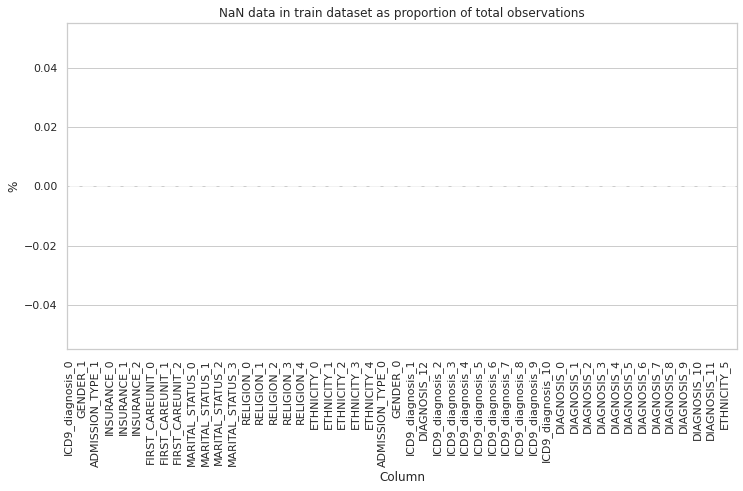

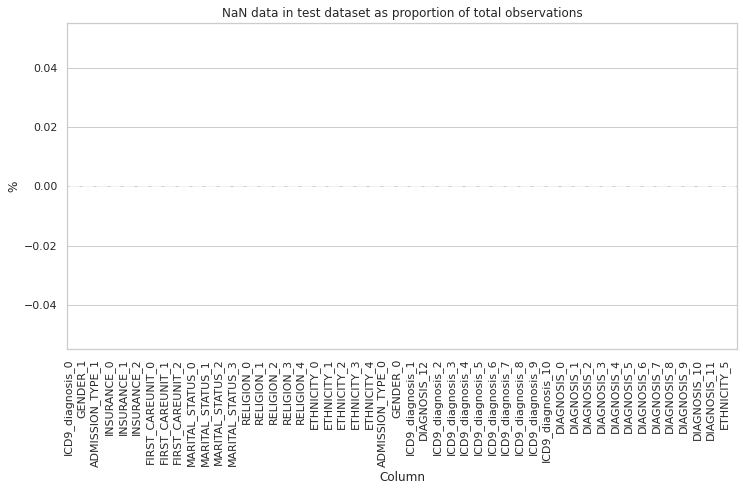

In [53]:
# Investigate missing data
my_plots.missing_plot(df_train_dumm, 'train'); my_plots.missing_plot(df_test_dumm, 'test')

So there are no missing values left for the categorical features.

## 3.5 Concatenate Numerical and Categorical Features

In [54]:
# Concatenate num and cat feats
X_train = pd.concat([df_train_scl, df_train_dumm], axis = 1)
X_test = pd.concat([df_test_scl, df_test_dumm], axis = 1)

In [55]:
# Also Add subject id (to be used for merge)
X_train = pd.concat([X_train, df_train_fillna['subject_id']], axis = 1)
X_test = pd.concat([X_test, df_test_fillna['subject_id']], axis = 1)

## 3.5 Merge Co-Morbidities

Please refer to the auxiliary notebook `comorb_transform.ipynb` ([this GitHub-link](https://github.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-1-kNN/comorb_transform.ipynb)) where comorbidities are transformed using the `icd` package in `R`.

In [56]:
# Add comorbidities that are already one-hot encoded
#comorb_add = comorb.drop('charlson_score', axis = 1)
comorb_add = comorb
comorb_add

,subject_id,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV,charlson_score
1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1000,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,5
4,10000,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,6
5,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46516,9999,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
46517,99991,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2
46518,99992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46519,99995,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3


In [57]:
comorb_add.iloc[:,18]

1        0
2        1
3        5
4        6
5        0
        ..
46516    1
46517    2
46518    0
46519    3
46520    1
Name: charlson_score, Length: 46520, dtype: int64

In [58]:
# Merge comorb on train
merge_train = X_train.merge(comorb_add, 
                            how = 'left', 
                            on = "subject_id",
                            indicator = True)
print(merge_train['_merge'].value_counts())
print(merge_train.isna().any())

both          20885
left_only         0
right_only        0
Name: _merge, dtype: int64
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
                  ...  
LiverSevere       False
Mets              False
HIV               False
charlson_score    False
_merge            False
Length: 95, dtype: bool


In [59]:
# Merge comorb on test
merge_test = X_test.merge(comorb_add, how = 'left', on = "subject_id", indicator = True)
print(merge_test['_merge'].value_counts())
print(merge_test.isna().any())

both          5221
left_only        0
right_only       0
Name: _merge, dtype: int64
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
                  ...  
LiverSevere       False
Mets              False
HIV               False
charlson_score    False
_merge            False
Length: 95, dtype: bool


All unique `subject_id`s are found in both the training dataset as well as in the the comorbidities data.

In [60]:
# Set indices from X_train and X_train respectively
merge_train = merge_train.set_index(X_train.index)
merge_test = merge_test.set_index(X_test.index)

In [61]:
# Drop merge indicator and id
merge_train = merge_train.drop(['subject_id', '_merge'], axis = 1)
merge_test = merge_test.drop(['subject_id', '_merge'], axis = 1)

# rename
X_train = merge_train
X_test = merge_test

## 3.6 Inspect Final Estimation Samples

In [62]:
print("Shape: ", X_train.shape)
X_train.head(7)

Shape:  (20885, 93)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV,charlson_score
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,1.297567,1.900397,2.341278,-0.975958,-0.995501,-0.751956,-0.195461,0.084999,-0.121493,0.188658,...,0,0,0,0,1,0,0,0,0,6
221004,-0.450986,0.227521,-0.395788,-0.120383,-1.247251,-0.743192,0.392303,-0.744659,0.201782,0.118964,...,0,0,0,0,0,0,0,0,0,0
296315,0.759551,-0.346037,0.424957,-0.177421,-0.533959,-0.380797,0.056438,-1.107635,-0.516797,0.537129,...,0,1,0,0,1,0,0,0,0,5
245557,0.423291,1.087857,0.892876,-0.405575,-0.659834,-0.728843,-1.203058,0.033146,-1.875188,-0.577978,...,0,0,0,0,0,0,0,0,0,3
225281,-0.120739,-0.113387,-0.151619,-0.042211,0.089747,0.036505,-0.145878,-0.014736,-0.190156,-0.066901,...,0,0,0,1,1,1,0,0,0,9
287519,0.019779,1.183450,0.833734,0.906307,0.179333,0.555008,1.315933,-0.018708,1.114289,1.094682,...,0,0,0,0,0,0,0,0,0,0
231164,-0.383734,0.514299,0.148065,0.735192,-0.114375,0.176910,0.392303,-0.848367,-0.555072,0.885600,...,0,1,0,0,1,0,0,0,0,6


In [63]:
print("Shape: ", X_test.shape)
X_test.head(7)

Shape:  (5221, 93)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV,charlson_score
icustay_id,,,,,,,,,,,,,,,,,,,,,
208169,-0.787246,-0.728408,0.004220,-0.804843,0.095417,-1.236719,-0.363394,-0.589098,-0.953039,-0.229507,...,0,0,0,0,0,0,0,0,0,1
251754,1.432071,1.900397,1.950365,-1.032997,-0.324167,-1.073878,-0.195461,-0.122415,0.278583,-0.438590,...,0,1,0,0,0,0,0,0,0,1
242171,2.440851,1.279043,2.126268,0.107770,-0.575917,-0.175031,0.560236,-0.640952,0.380736,0.258352,...,0,0,0,0,0,0,0,0,0,0
263035,0.154283,-0.011462,-0.101394,-1.090035,0.724792,0.469216,-0.447360,0.551682,0.031146,-0.717367,...,0,0,0,0,0,0,0,0,0,1
279388,1.028559,0.896671,0.876089,-0.291498,-0.282209,-0.507678,0.644202,2.314707,0.937444,0.676517,...,1,1,0,0,0,0,0,0,0,4
262988,-2.065034,-1.588745,-2.226185,-1.831534,-2.925585,-2.698158,-0.279428,-1.315050,-0.856299,-0.787061,...,0,0,0,0,0,0,0,0,0,0
291777,2.239095,2.282768,2.118298,1.362614,1.647876,1.332247,1.148000,1.122073,1.303198,1.094682,...,0,0,0,0,0,0,0,0,0,0


# **4. Set Different Estimation Samples**

## 4.1 Principal Component Analysis

In the end I ended up not using the PCA sample. I still leave my exploration below.

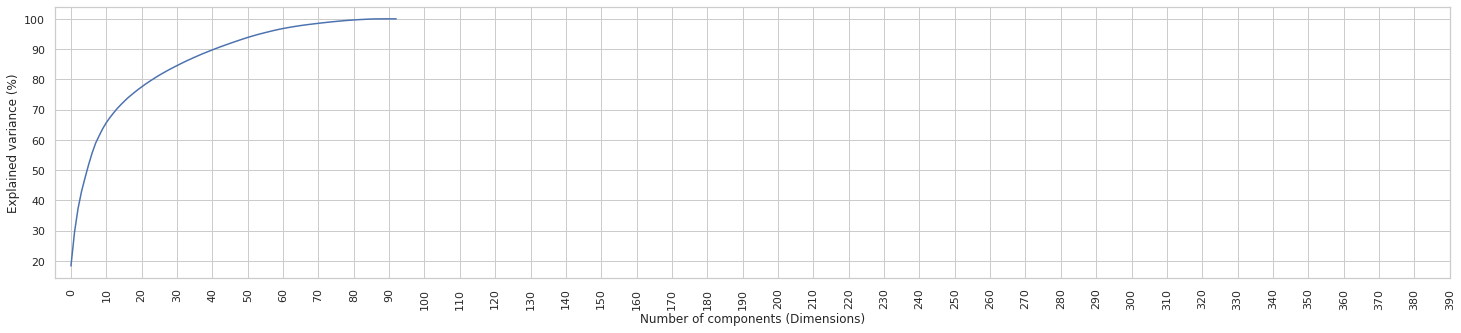

In [64]:
# Apply PCA to training data
pca = PCA(n_components = None)
pca.fit(X_train)

# Make scree plot
my_plots.make_scree_plot(pca)

No real elbow is apparent. I will choose 30 components

In [65]:
# Instantiate PCA with 30 components
pca = PCA(n_components=30)

# Fit to training data
X_pca = pca.fit(X_train)

# Transform train and test with the pipeline fittes on train data
X_pca_train, X_pca_test = pca.transform(X_train), pca.transform(X_test)

# pd.dataframes
X_pca_train, X_pca_test = pd.DataFrame(X_pca_train, index = X_train.index), pd.DataFrame(X_pca_test, index = X_test.index)

## 4.2 Random Sample

For testing codes below

In [66]:
y_train, X_train, X_test = y_train, X_train, X_test

In [67]:
# Random sample while building code
p = 0.05 #<- random sample frac

y_random, X_random, X_test_random = y_train.sample(frac = p), X_train.sample(frac = p), X_test.sample(frac = p)
print(X_random.shape); print(y_random.shape); print(X_test_random.shape)
print(X_random.head(3) ); print(y_random.head(4) )

(1044, 93)
(1044,)
(261, 93)
            HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  \
icustay_id                                                            
264491           1.835583       0.562096        1.382622   0.392962   
209176          -0.921750      -1.732134       -1.575463   1.248537   
203077          -0.585490      -1.015187       -0.873510  -0.063345   

            SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  \
icustay_id                                                               
264491      -0.072417    0.350551   -0.951158   -1.470611    -1.517346   
209176       2.612918    2.279203   -0.195461   -0.848367    -0.471897   
203077       0.934584    0.640408    0.140404   -0.744659    -0.149673   

            MeanBP_Min  ...  LiverMild  DM  DMcx  Paralysis  Renal  Cancer  \
icustay_id              ...                                                  
264491       -0.368896  ...          0   0     0          0      0       0   
209176    

# **6. Hyperparameter Optimization**

First, set parameters for different estimators. Then, create iterable using `zip` to run loop over different estimators

In [68]:
# DT
#max_leaf_nodes = [int(x) for x in np.linspace(1, 5, num = 5)]
max_leaf_nodes = [int(x) for x in np.linspace(2, 5, num = 4)]
min_impurity_decrease = [float(x) for x in np.linspace(0, 1, num = 5)]

dt_params = {'max_leaf_nodes': max_leaf_nodes,
             'min_impurity_decrease': min_impurity_decrease}

# RF 
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 5)]
#max_leaf_nodes = [int(x) for x in np.linspace(1, 5, num = 5)]
max_leaf_nodes = [int(x) for x in np.linspace(2, 5, num = 4)]
min_impurity_decrease = [float(x) for x in np.linspace(0, 1, num = 5)]

rf_params = {'n_estimators': n_estimators,
             'max_leaf_nodes': max_leaf_nodes,
             'min_impurity_decrease': min_impurity_decrease}

# AdaBoost
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 5)]
#learning_rate = [float(x) for x in np.linspace(0, 1, num = 5)]
learning_rate = [float(x) for x in np.linspace(0.1, 1, num = 5)]

ada_params = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,}

# Gradient Boost
gboost_params = ada_params


# XGBoost
xgb_params = {'num_boost_round': [10, 25, 50],
              'eta': [0.05, 0.1, 0.3],
              #'subsample': [0.9, 1.0],
              #'colsample_bytree': [0.9, 1.0],
              'max_depth': [3, 4, 5]}


# Create iterator
names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boost', 'XGBoost']
regressors = [DecisionTreeRegressor(),
              RandomForestRegressor(),
              AdaBoostRegressor(),
              GradientBoostingRegressor(),
              xgboost.XGBRegressor()]
params = [dt_params, 
          rf_params, 
          ada_params, 
          gboost_params,
          xgb_params]

print(params)
regs_clf = zip(names, regressors, params)

[{'max_leaf_nodes': [2, 3, 4, 5], 'min_impurity_decrease': [0.0, 0.25, 0.5, 0.75, 1.0]}, {'n_estimators': [50, 87, 125, 162, 200], 'max_leaf_nodes': [2, 3, 4, 5], 'min_impurity_decrease': [0.0, 0.25, 0.5, 0.75, 1.0]}, {'n_estimators': [50, 87, 125, 162, 200], 'learning_rate': [0.1, 0.325, 0.55, 0.775, 1.0]}, {'n_estimators': [50, 87, 125, 162, 200], 'learning_rate': [0.1, 0.325, 0.55, 0.775, 1.0]}, {'num_boost_round': [10, 25, 50], 'eta': [0.05, 0.1, 0.3], 'max_depth': [3, 4, 5]}]


Run loop over different estimators using `BayesSearchCV` from `skopt`

In [69]:
# Start timer
start = datetime.now()

# Set data
#df, target = X_random, y_random
df, target = X_train, y_train

best_ests = []
# Run grid search over different estimators and report metrics
for name, reg, param in regs_clf:
  # Instantiate grid
  grid = BayesSearchCV(estimator = reg, 
                       search_spaces = param,
                       scoring = 'neg_mean_squared_error',
                       cv = 5,
                       n_iter = 25,
                       n_jobs = -1,
                       verbose = 0)
  
  # Fit grid and calc score
  grid.fit(df, target)
  cvs = cross_val_score(reg, df, target, scoring = 'neg_mean_squared_error', cv = 5)
  rmse = sqrt((-1)*cvs.mean())
  
  # Save results
  best_ests.append((name, rmse, grid.best_estimator_))

# Print runtime
print('Runtime:', datetime.now() - start); print('/n')

# Print winner
best_ests.sort(key = lambda x: x[1])
print('And the winner is:', best_ests[0][0], 'with a RMSE score of {:0.2f}'.format(best_ests[0][1]))
print('Best model was', best_ests[0][2])

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

[21:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Runtime: 1:17:12.232667
/n
And the winner is: XGBoost with a RMSE score of 4.90
Best model was XGBRegressor(eta=0.1, max_depth=5, num_boost_round=25)


In [70]:
best_ests

[('XGBoost',
  4.897090474657317,
  XGBRegressor(eta=0.1, max_depth=5, num_boost_round=25)),
 ('Gradient Boost',
  4.90861691531888,
  GradientBoostingRegressor(n_estimators=200)),
 ('Random Forest',
  5.041573465457894,
  RandomForestRegressor(max_leaf_nodes=5, n_estimators=87)),
 ('Decision Tree', 7.313605045848149, DecisionTreeRegressor(max_leaf_nodes=4)),
 ('AdaBoost', 12.498289622421627, AdaBoostRegressor(learning_rate=0.1))]

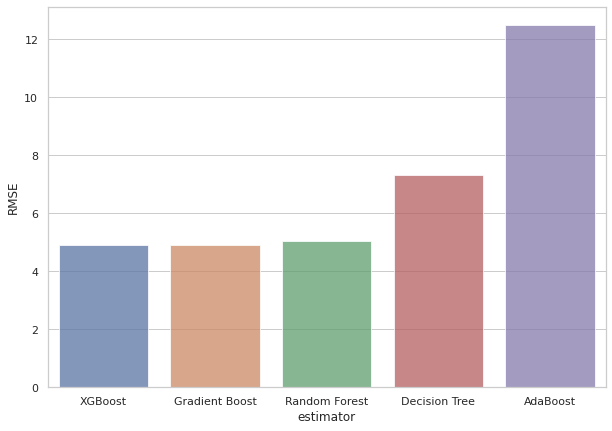

In [71]:
# Df for plot
regs_df = pd.DataFrame(best_ests, columns =['estimator', 'RMSE', 'spec']).sort_values('RMSE', ascending = True)
regs_df = regs_df.drop(['spec'], axis = 1)

# Plot
sns.set_theme(style="whitegrid")
sns.barplot(x = "estimator", y = "RMSE", data = regs_df, alpha = .75)

## 6.1 Run Model with Optimal Hyperparameters

In [72]:
# Set data
#df, target = X_random, y_random
df, target = X_train, y_train

# Instantiate
opt_model = best_ests[0][2]

# Fit
opt_model.fit(df, target)

# Estimate RMSE score
cvs = cross_val_score(opt_model, df, target, scoring = 'neg_mean_squared_error', cv = 5)
print("Optimal", best_ests[0][0], "w. RMSE score: {:0.2f} \n".format(sqrt((-1)*cvs.mean())))

[21:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Optimal XGBoost w. RMSE score: 4.89 



In [73]:
path = '/content/drive/My Drive/--T2-CML2/Project2_DT_Ensemble/preds/'

# Prediction on test data
y_hat_test = opt_model.predict(X_test)
y_hat_test = pd.Series(y_hat_test)

# Date for filename
date_filename = str(datetime.now().strftime('%Y_%m_%d_%H_%M'))

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({'icustay_id': X_test.index, 'LOS': y_hat_test})
test_predictions_submit.to_csv(path + 'preds-' + 'HyperOpt-' + date_filename + '.csv', index = False)

Link to Kaggle competition: [https://www.kaggle.com/c/cml2-length-of-stay-prediction-with-decision-tree](https://www.kaggle.com/c/cml2-length-of-stay-prediction-with-decision-tree)